# XAI for exploratory analysis

In [1]:
from src.preprocess.model_data import ModelLoaders, FreezeModelLoader
import pandas as pd
from typing import *
from src.preprocess.dataset import Dataset, DatasetConfig
from src.preprocess.result import ResultData


dataset_names: Optional[List[str]]

dataset = Dataset(DatasetConfig(type="clean"))

result_data = dataset.get()



ml = ModelLoaders(df=result_data.ml_ready)
modelfile = "data/20--model/LSTM"


package = ml.load(modelfile)
y_true, y_pred = ml.test(ml.package)

model = package.model
train_loader = package.train_loader
val_loader   = package.val_loader
test_loader  = package.test_loader
feat_cols    = package.feat_cols
label_col    = package.label_col



[ModelLoaders] package loaded from PosixPath('data/20--model/LSTM.pt')
Test  MSE : 0.004744
Test  RMSE: 0.068877
Test  R²  : 0.9968


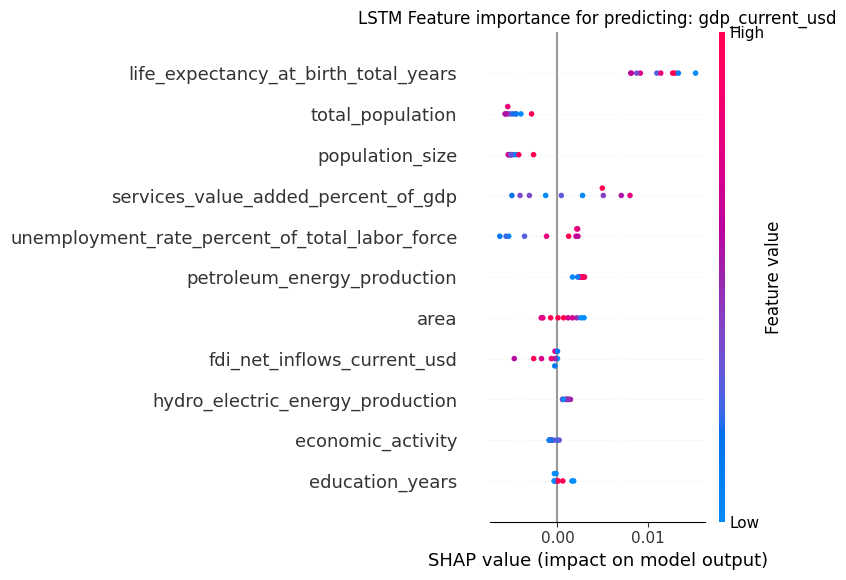

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # CPU‐only

import random
import numpy as np
import torch
import shap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

model.cpu().eval()

B = 32
bg_loader = DataLoader(train_loader.dataset, batch_size=B, shuffle=False)
bg_X, _  = next(iter(bg_loader))    # now guaranteed to work
bg_X = bg_X.detach().cpu()           # shape: (B, time, F)

explainer = shap.GradientExplainer(
    model,
    bg_X,
    local_smoothing=0
)

Xs, _ = next(iter(test_loader))
Xs = Xs.detach().cpu()

s3d = explainer.shap_values(Xs)[0]    # (time, F, 1)
s2d = np.squeeze(s3d, axis=-1)        # (time, F)
X_2d = Xs.mean(dim=0).numpy()         # (time, F)

assert s2d.shape == X_2d.shape == (Xs.shape[1], len(feat_cols)), (
    f"shapes mismatch: s2d={s2d.shape}, X_2d={X_2d.shape}, #feat_cols={len(feat_cols)}"
)

plt.figure(figsize=(14, 0.35 * len(feat_cols) + 2))
rng = np.random.RandomState(123)
shap.summary_plot(
    s2d,
    X_2d,
    feature_names=feat_cols,
    plot_type="dot",
    max_display=len(feat_cols),
    show=False,
    rng=rng
)
plt.title(f"LSTM Feature importance for predicting: {label_col}")
plt.tight_layout()
plt.show()
